# Grid Search

## Importing the dataset

In [1]:
dataset = read.csv('Social_Network_Ads.csv')
dataset = dataset[3:5]
head(dataset)

Age,EstimatedSalary,Purchased
19,19000,0
35,20000,0
26,43000,0
27,57000,0
19,76000,0
27,58000,0


## Encoding the target feature as factor

In [3]:
dataset$Purchased = factor(dataset$Purchased, levels=c(0, 1))
head(dataset)

Age,EstimatedSalary,Purchased
19,19000,0
35,20000,0
26,43000,0
27,57000,0
19,76000,0
27,58000,0


## Splitting the dataset into the Training set and Test set

In [4]:
library(caTools)
set.seed(123)

split = sample.split(dataset$Purchased, SplitRatio=0.75)
training_set = subset(dataset, split == TRUE)
test_set = subset(dataset, split == FALSE)

Warning message:
"package 'caTools' was built under R version 3.6.3"

## Feature Scaling

In [5]:
training_set[-3] = scale(training_set[-3])
test_set[-3] = scale(test_set[-3])

In [6]:
head(training_set)

,Age,EstimatedSalary,Purchased
1,-1.7655475,-1.4733414,0
3,-1.0962966,-0.7883761,0
6,-1.0006894,-0.3602727,0
7,-1.0006894,0.3817730,0
8,-0.5226531,2.2654277,1
10,-0.2358313,-0.1604912,0


## Fitting Kernel SVM to the Training set

In [7]:
library(e1071)

classifier = svm(formula=Purchased ~ .,
                 data=training_set,
                 type='C-classification',
                 kernel='radial')

Warning message:
"package 'e1071' was built under R version 3.6.3"

In [8]:
classifier


Call:
svm(formula = Purchased ~ ., data = training_set, type = "C-classification", 
    kernel = "radial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  77


## Predicting the Test set results

In [12]:
y_pred = predict(classifier, newdata=test_set[-3])
head(data.frame(y_test=test_set[3], y_pred=y_pred))

,Purchased,y_pred
2,0,0
4,0,0
5,0,0
9,0,0
12,0,0
18,1,1


## Making the Confusion Matrix

In [10]:
cm = table(test_set[, 3], y_pred)
cm

   y_pred
     0  1
  0 58  6
  1  4 32

## Applying k-Fold Cross Validation

In [13]:
library(caret)

folds = createFolds(training_set$Purchased, k=10)
cv = lapply(folds, function(x)  {
                                training_fold=training_set[-x, ]
                                test_fold=training_set[x, ]
                                classifier=svm(formula=Purchased ~ .,
                                                data=training_fold,
                                                type='C-classification',
                                                kernel='radial')
                                y_pred=predict(classifier, newdata=test_fold[-3])
                                cm=table(test_fold[, 3], y_pred)
                                accuracy=(cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] + cm[1,2] + cm[2,1])
                                return(accuracy)
                                })
accuracy = mean(as.numeric(cv))

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [14]:
accuracy

[1] 0.9162848

## Applying Grid Search to find the best parameters

In [15]:
library(caret)

classifier = train(form=Purchased ~ ., data=training_set, method='svmRadial')
classifier
classifier$bestTune

Support Vector Machines with Radial Basis Function Kernel 

300 samples
  2 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 300, 300, 300, 300, 300, 300, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.9145693  0.8130036
  0.50  0.9159184  0.8157252
  1.00  0.9186723  0.8215380

Tuning parameter 'sigma' was held constant at a value of 1.327355
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 1.327355 and C = 1.

,sigma,C
3,1.327355,1


## Visualising the Training set results

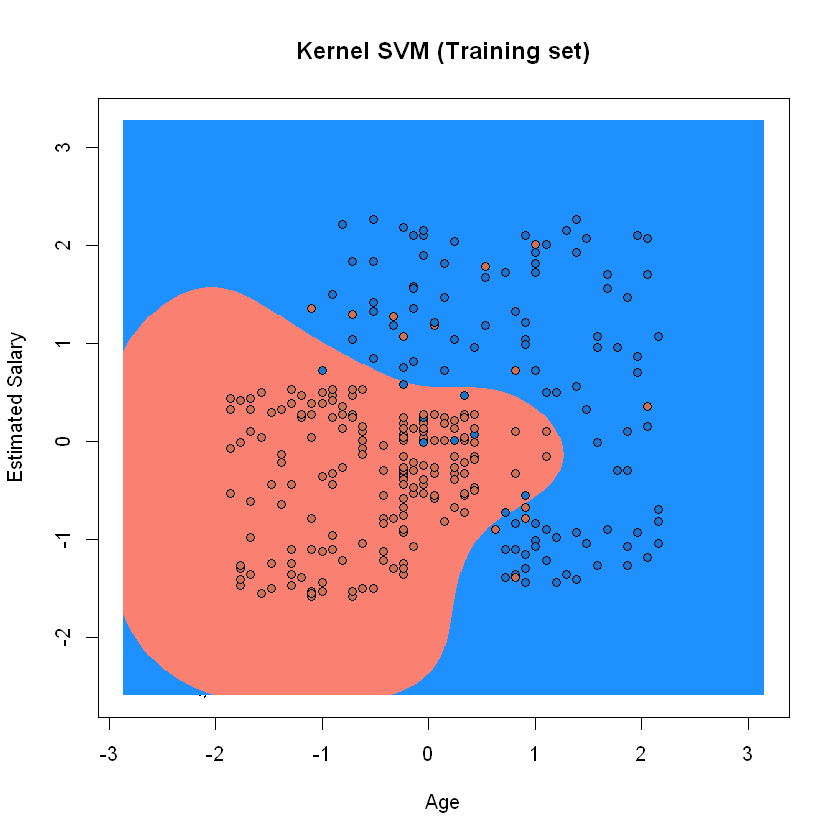

In [16]:
set = training_set
X1 = seq(min(set[, 1]) - 1, max(set[, 1]) + 1, by=0.01)
X2 = seq(min(set[, 2]) - 1, max(set[, 2]) + 1, by=0.01)
grid_set = expand.grid(X1, X2)
colnames(grid_set) = c('Age', 'EstimatedSalary')
y_grid = predict(classifier, newdata=grid_set)

plot(set[, -3],
     main='Kernel SVM (Training set)',
     xlab='Age', ylab='Estimated Salary',
     xlim=range(X1), ylim=range(X2))
contour(X1, X2, matrix(as.numeric(y_grid), length(X1), length(X2)), add=TRUE)
points(grid_set, pch='.', col=ifelse(y_grid == 1, 'dodgerblue', 'salmon'))
points(set, pch=21, bg=ifelse(set[, 3] == 1, 'dodgerblue3', 'salmon3'))

## Visualising the Test set results

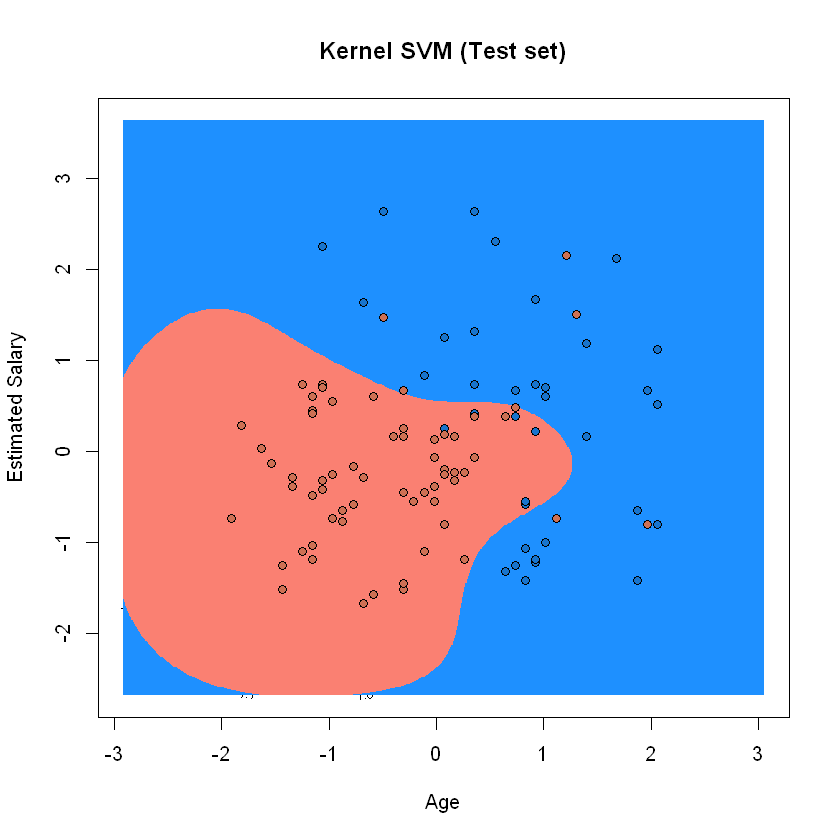

In [17]:
set = test_set
X1 = seq(min(set[, 1]) - 1, max(set[, 1]) + 1, by=0.01)
X2 = seq(min(set[, 2]) - 1, max(set[, 2]) + 1, by=0.01)
grid_set = expand.grid(X1, X2)
colnames(grid_set)=c('Age', 'EstimatedSalary')
y_grid = predict(classifier, newdata=grid_set)

plot(set[, -3], main='Kernel SVM (Test set)',
     xlab='Age', ylab='Estimated Salary',
     xlim=range(X1), ylim=range(X2))
contour(X1, X2, matrix(as.numeric(y_grid), length(X1), length(X2)), add=TRUE)
points(grid_set, pch='.', col=ifelse(y_grid == 1, 'dodgerblue', 'salmon'))
points(set, pch=21, bg=ifelse(set[, 3] == 1, 'dodgerblue3', 'salmon3'))